In [1]:
# hopefully this will help

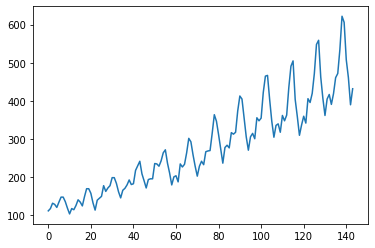

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
 
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
plt.plot(timeseries)
plt.show()

In [3]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [4]:
import torch
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [5]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1, 1]) torch.Size([95, 1, 1])
torch.Size([47, 1, 1]) torch.Size([47, 1, 1])


C:\Users\trist\AppData\Local\Temp\ipykernel_47008\2861746758.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor(X), torch.tensor(y)


In [6]:
...
import torch.nn as nn
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [8]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

Epoch 0: train RMSE 225.8592, test RMSE 422.2062
Epoch 100: train RMSE 186.9659, test RMSE 381.5728
Epoch 200: train RMSE 154.5694, test RMSE 346.7072
Epoch 300: train RMSE 126.5503, test RMSE 315.0421
Epoch 400: train RMSE 103.2262, test RMSE 286.1790
Epoch 500: train RMSE 85.0452, test RMSE 260.3425
Epoch 600: train RMSE 68.8423, test RMSE 235.5732
Epoch 700: train RMSE 55.7150, test RMSE 212.5428
Epoch 800: train RMSE 45.7431, test RMSE 191.7980
Epoch 900: train RMSE 39.1158, test RMSE 173.1823
Epoch 1000: train RMSE 33.1265, test RMSE 157.4427
Epoch 1100: train RMSE 29.8058, test RMSE 144.2615
Epoch 1200: train RMSE 27.5151, test RMSE 132.9378
Epoch 1300: train RMSE 25.8618, test RMSE 124.5573
Epoch 1400: train RMSE 25.5834, test RMSE 118.2637
Epoch 1500: train RMSE 24.5094, test RMSE 112.9504
Epoch 1600: train RMSE 23.9859, test RMSE 108.0708
Epoch 1700: train RMSE 23.8960, test RMSE 105.3761
Epoch 1800: train RMSE 23.8913, test RMSE 102.0875
Epoch 1900: train RMSE 23.4195, test R

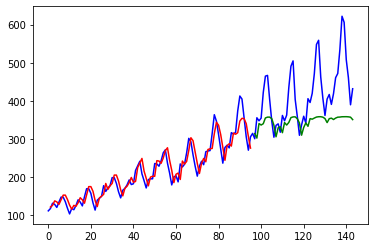

In [9]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()